In [33]:
import torch
import os

class Para:
    feature_column_start_name = 'ep_ratio_ttm'
    feature_column_end_name = 'BR'

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_path = 'data/cs_space_1d_rate_20d_2022_pre'
    model_path = 'models/model_c2_y1_p[[0.0, 0.1], [0.9, 1.0]]_b32_lr0.001_d0.5_e500.pth'

    classification_n = 2

    month_num = len(os.listdir(data_path))

para = Para()
print(para.month_num)

30


In [34]:
import numpy as np
import torch
from my_utils.model_class import MLP
import pandas as pd

def insert_predict(df: pd.DataFrame, model_path, out_nums: int, column_name: str) -> pd.DataFrame:

    # 加载模型
    model = MLP(in_nums=22, out_nums=out_nums, drop_p=0.5)
    model.load_state_dict(torch.load(model_path, map_location=para.device))
    model = model.to(para.device)

    # 运算
    model.eval()
    predict_tensor = model(torch.Tensor(df.loc[:, para.feature_column_start_name: para.feature_column_end_name].values).to(device=para.device))

    # 插入 predict_tensor 列
    df.insert(loc=0, column='predict_tensor_'+column_name, value=np.nan)
    # 插入 predict_return_bin 列
    df.insert(loc=0, column='predict_return_bin_'+column_name, value=np.nan)

    df['predict_tensor'+'_'+column_name] = predict_tensor.to(device='cpu').detach().numpy().tolist()
    df['predict_return_bin'+'_'+column_name] = predict_tensor.to(device='cpu').detach().numpy().argmax(1)

    return df

In [35]:
import torchmetrics
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F

precision = torchmetrics.Precision(average='none', num_classes=para.classification_n)
time_begin = time.time()

plot_df = pd.DataFrame()

# for i_csv in range(48, 59+1):
# for i_csv in range(0, 2):
for i_csv in range(para.month_num):
    print()
    print('i_csv: {}'.format(i_csv))
    print('use time: {}'.format(time.time() - time_begin))

    df = pd.read_csv(para.data_path +'/' + str(i_csv) + '.csv', index_col='order_book_id')

    # 插入预测数据
    df = insert_predict(df=df, model_path=para.model_path, out_nums=para.classification_n, column_name='2c')

    # 综合多个预测数据
    df.insert(loc=0, column='predict_return_bin', value=np.nan)
    df.loc[df['predict_return_bin_2c'].isin([0,]), 'predict_return_bin'] = 0
    df['predict_return_bin'].replace(to_replace=np.nan, value=1, inplace=True)
    df['predict_return_bin'] = df['predict_return_bin'].astype('int64')

    df.insert(loc=0, column='probability', value=np.nan)
    for stock_id in df.index:
        df.loc[stock_id, 'probability'] = F.softmax(torch.tensor(df.loc[stock_id, 'predict_tensor_2c']), dim=0).numpy()[0]
        # df.loc[stock_id, 'probability'] = torch.tensor(df.loc[stock_id, 'predict_tensor_2c']).numpy()[0]

    # 插入实际 return_bin 列
    df.insert(loc=0, column='return_bin', value=np.nan)
    df.loc[df['yield_rate'] > 0.0, 'return_bin'] = 0
    df['return_bin'].replace(to_replace=np.nan, value=1, inplace=True)
    df['return_bin'] = df['return_bin'].astype('int64')

    # # 计算精确率
    df = df.sort_values(by='probability', ascending=False)

    pred = torch.tensor(df['predict_return_bin'][0:100]).type(torch.LongTensor)
    target = torch.tensor(df['return_bin'][0:100]).type(torch.LongTensor)
    print('date: {}' .format(df['date'][0]))
    print(precision(preds=pred, target=target))

    print(df.loc[df['yield_rate']>0.0, 'predict_return_bin'].value_counts())

    plot_df = pd.concat([plot_df, pd.DataFrame(data=[[df['date'][0] ,precision(preds=pred, target=target).detach().numpy()[0]]], columns=['date', 'precision'])])


i_csv: 0
use time: 0.0029942989349365234
date: 2022-01-04
tensor([0.7600, 0.0000])
0    1529
1     362
Name: predict_return_bin, dtype: int64

i_csv: 1
use time: 3.6456496715545654
date: 2022-01-05
tensor([0.6500, 0.0000])
0    1463
1     375
Name: predict_return_bin, dtype: int64

i_csv: 2
use time: 5.527101993560791
date: 2022-01-06
tensor([0.7200, 0.0000])
0    1475
1     343
Name: predict_return_bin, dtype: int64

i_csv: 3
use time: 7.606829881668091
date: 2022-01-07
tensor([0.6100, 0.0000])
0    1503
1     337
Name: predict_return_bin, dtype: int64

i_csv: 4
use time: 9.726357221603394
date: 2022-01-10
tensor([0.6500, 0.0000])
0    1493
1     363
Name: predict_return_bin, dtype: int64

i_csv: 5
use time: 11.970667123794556
date: 2022-01-11
tensor([0.6800, 0.0000])
0    1411
1     384
Name: predict_return_bin, dtype: int64

i_csv: 6
use time: 13.837813377380371
date: 2022-01-12
tensor([0.7000, 0.0000])
0    1446
1     374
Name: predict_return_bin, dtype: int64

i_csv: 7
use time: 

In [36]:
print()
print('average precision: {}' .format(precision.compute()))
precision.reset()


average precision: tensor([0.6300, 0.0000])


In [37]:
plot_df['date'] = pd.to_datetime(plot_df['date'])
plot_df.set_index('date', inplace=True)
plot_df

,precision
date,
2022-01-04,0.76
2022-01-05,0.65
2022-01-06,0.72
2022-01-07,0.61
2022-01-10,0.65
2022-01-11,0.68
2022-01-12,0.70
2022-01-13,0.63
2022-01-14,0.75


<AxesSubplot:xlabel='date'>

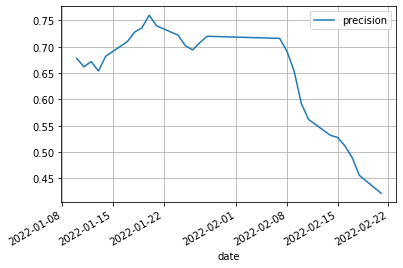

In [38]:
plot_df.rolling(5).mean().plot(grid=True)

## 测试模型预测

In [39]:
import torch
from my_utils.model_class import MLP

model = MLP(in_nums=22, out_nums=2, drop_p=0.5)
model.load_state_dict(torch.load('models/model_c2_p[[0.0, 0.3], [0.7, 1.0]]_b32_lr0.001_d0.5_e500.pth', map_location=para.device))
model = model.to(para.device)

model.eval()
a = model(torch.Tensor([[0.5]*22]*4).to(device=para.device))
a

tensor([[-0.1420, -0.2949],
        [-0.1420, -0.2949],
        [-0.1420, -0.2949],
        [-0.1420, -0.2949]], device='cuda:0', grad_fn=<AddmmBackward>)